<a href="https://colab.research.google.com/github/elliemci/vision-transformer-models/blob/main/object_detection/crack_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install -q datasets transformers

In [ ]:
!pip install huggingface_hub

In [ ]:
!pip install roboflow

In [ ]:
!pip install roboflow2huggingface

In [3]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/ColabNotebooks/ExplainableAI/object_detection

Mounted at /content/drive
/content/drive/MyDrive/ColabNotebooks/ExplainableAI/object_detection


# Crack Detection with Conditional DETR

## Import a Roboflow dataset

Load a Roboflow building cracks images dataset and convert to Hugging Face object detection and fine tune a variant of DETR, [conditional DETR](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/2108.06152), which combines a convolutional backbone with an encoder-decoder Transformer. Using images from surveillance cameras, the model identifies the presence of cracks and can estimate building construction quality and risks.

In [ ]:
from roboflow2huggingface import roboflow_to_huggingface_pipeline
from google.colab import userdata

userdata.get('roboflow_api_key')
userdata.get('huggingface_hub_access_token')

rf_api_key = input('Enter your Roboflow API key: ')
hf_token = input('Enter your Hugging Face write token: ')

# create a project on Roboflow, connect to a building cracks dataset on Roboflow
# and export dataset to Hugging Face dataset account
roboflow_to_huggingface_pipeline(
    roboflow_universe_url = 'https://universe.roboflow.com/crack-7rsjb/crack-detection-ol3yi/dataset/1',
    roboflow_api_key = rf_api_key,  #'roboflow_api_key',
    hf_dataset_id = 'elliemci/building_cracks',
    hf_write_token = hf_token #'huggingface_hub_access_token'
)

# uploade dataset to Hugging Face repository

## Load dataset from Hugging Face

In [19]:
import os
from datasets import load_dataset
from huggingface_hub import login, HfFolder

userdata.get('huggingface_hub_access_token')

login()

#os.environ["HF_TOKEN"] = "your_access_token"
userdata.get('HF_TOKEN')
HfFolder.save_token('huggingface_hub_access_token')

ds = load_dataset("elliemci/building_cracks", name="full")

building_cracks.py:   0%|          | 0.00/6.04k [00:00<?, ?B/s]

The repository for elliemci/building_cracks contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/elliemci/building_cracks.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


train.zip:   0%|          | 0.00/10.6M [00:00<?, ?B/s]

valid.zip:   0%|          | 0.00/2.96M [00:00<?, ?B/s]

test.zip:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [20]:
ds

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1673
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 477
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 244
    })
})

In [ ]:
# the feature metadata of the object column in the split contains the vehichle's categories
print(f"dataset categories: {ds['train'].features['objects'].feature['category'].names}")

In [28]:
# get unique category IDs
unique_category_ids = set()
for split in ds:  # iterate through 'train', 'test'
    for example in ds[split]:
        unique_category_ids.update(example['objects']['category'])

# create mappings between category indices and labels
id2label = {
    i: feature
    for i, feature in enumerate(ds['train'].features['objects'].feature['category'].names)}
label2id = {v: k for k, v in id2label.items()}

print(f" ids to labels mapping: {id2label}")
print(f" labels to ids mapping: {label2id}")
print()
# print category names
print("Object Category Names:")
for category_id in unique_category_ids:
    category_name = id2label.get(category_id, "Unknown")  # handle unknown IDs
    print(f"- {category_name}")

 ids to labels mapping: {0: 'crack'}
 labels to ids mapping: {'crack': 0}

Object Category Names:
- crack


In [35]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def display_annotated_image(example, id2label):
  # display image with detected object category names
  print()
  plt.imshow(example['image'])
  plt.axis("off")

  # draw bounding boxes and category labels
  ax = plt.gca()

  # a loop though each detected object bounding box
  for i in range(len(example['objects']['bbox'])):
    bbox = example['objects']['bbox'][i]
    x, y, w, h = bbox
    rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')

    ax.add_patch(rect)
    category_id = example['objects']['category'][i]
    category_name = id2label.get(category_id, "Unknown")
    plt.text(x, y, category_name, color='r', fontsize=12)

plt.show()

sample content:
image_id: 873
image: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=200x200 at 0x78739F2EB410>
width: 200
height: 200
objects: {'id': [874], 'area': [13333], 'bbox': [[61.0, 0.0, 67.0, 199.0]], 'category': [0]}


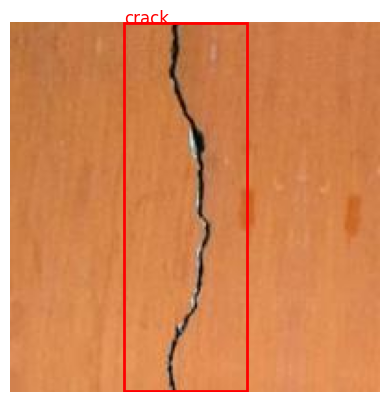

In [34]:
import random

rand_inx = random.randint(0, len(ds["train"]) - 1)
example = ds['train'][rand_inx]

# display example content
print(f"sample content:")
for key, value in example.items():
    print(f"{key}: {value}")

display_annotated_image(example, id2label)